# Healthcare Stroke Prediction

#1) Set Up

#Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import scipy.stats as st
import plotly.express as px
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

#Import the Dataset

In [5]:
URL = 'https://drive.google.com/file/d/1mVXZs_EMuWSK2kVqqsGQLbWB1RkRfPk6/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
df = pd.read_csv(path)
df.shape #view dimention of dataset

(5110, 12)

In [6]:
df.head() #preview the dataset

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#2) Preparation

#Explore Missing Values

Text(0.5, 1.0, 'Null Values in Data Frame')

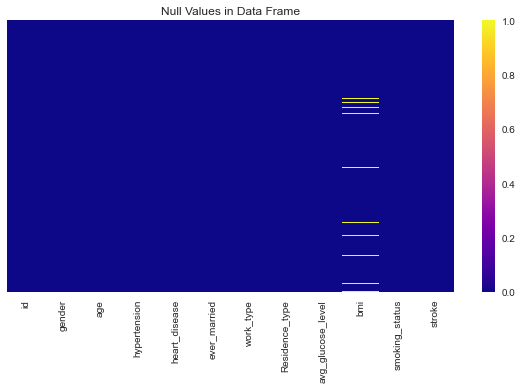

In [8]:
plt.style.use('seaborn')
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), yticklabels = False, cmap = 'plasma')
plt.title('Null Values in Data Frame')

In [9]:
# get the number of missing data points per column
missing_value_count = (df.isnull().sum())
print(missing_value_count[missing_value_count > 0])
# percent of data that is missing
total_cells = np.product(df.shape)
total_missing_value = missing_value_count.sum()
print('Percentage of missing value in Data Frame is:', total_missing_value / total_cells*100)
print('Total number of our cells is:', total_cells)
print('Total number of our missing value is:', total_missing_value)

bmi    201
dtype: int64
Percentage of missing value in Data Frame is: 0.32778864970645794
Total number of our cells is: 61320
Total number of our missing value is: 201


#Handling Missing Values

In [10]:
df['bmi'].fillna(df['bmi'].mean(),inplace=True)
df['bmi'].isnull().sum()

0

In [11]:
df.drop(['id'],axis=1,inplace=True)

#Clarify Features

1) age           - Age of the patient in Years

2) gender           - Sex of the Patient


*   Male
*   Female

3) hypertension            


*   0 = if the patient doesn't have hypertension
*   1 = if the patient has hypertension

4) avg_glucose_level - average glucose level in blood

5) bmi         - body mass index

6) stroke          


*   0 = if the patient had not a stroke
*   1 = if the patient had a stroke

7) heart_disease  


*   0 = if the patient doesn't have any heart diseases
*   1 = if the patient has a heart disease

8) work_type  


*  children

*   Govt_jov

*   Never_worked
*   Private


*   Self-employed

9) ever_married      


*   No
*   Yes

10) id   - unique identifier

11) Residence_type      


*   Rural
*   Urban

12) smoking_status            


*   formerly smoked
*   never smoked
*   smokes
*   Unknown

# Data Preparation

In [12]:
# Labeling data fields to Text value for easy interpretation of Visualization
data_eda = df.copy()
#hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
data_eda["hypertension"]     = df["hypertension"]    .map({1: "Yes",           0: "No"})
#1 if the patient had a stroke or 0 if not
data_eda["stroke"]     = df["stroke"]    .map({1: "Yes",           0: "No"})
#0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
data_eda["heart_disease"]  = df["heart_disease"] .map({1: "Yes" ,           0: "No"})

#Exploratory Data (EDA)

####PlotGraph Function

In [13]:
def cnditioning_linear_plot(x,y,hue,df):
    sns.lmplot(x=x, y=y, hue=hue, data=df,
               markers=["o", "x"], palette="Set1")

In [14]:
def count_bar_plot(df,x,hue,title):
    fig = sns.countplot(x=x, hue=hue, data=df)
    fig.set_title(title)

In [15]:
def pie_graph(df,title,values):   
    labels = df[values].value_counts().index
    values = df[values].value_counts()

    fig = go.Figure(data = [
        go.Pie(
        labels = labels,
        values = values,
        hole = .5)
    ])

    fig.update_layout(title_text = title)
    fig.show()

In [16]:
def distplot(x):
    ax = sns.distplot(data_eda[x], rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [17]:
def horizontal_bar_chart(df,x,y,color,title):    
    fig = px.bar(df, x=x, y=y, color=color,                  
                 height=600,
                 title=title)
    fig.show()

####Descriptive statistics

In [18]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


c:\Users\Rahmatullah\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Rahmatullah\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


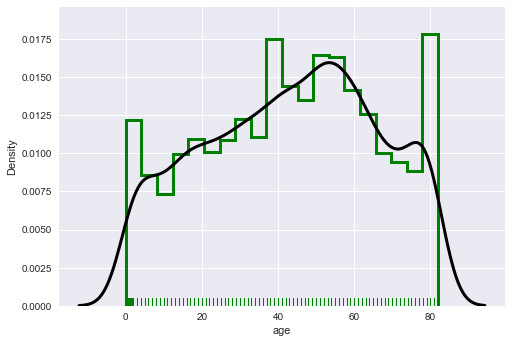

In [19]:
distplot('age')

In [20]:
## cohort analysis of age with output
def age_cohort(age):
    if   age >= 0 and age <= 20:
        return "0-20"
    elif age > 20 and age <= 40:
        return "20-40"
    elif age > 40 and age <= 50:
        return "40-50"
    elif age > 50 and age <= 60:
        return "50-60"
    elif age > 60:
        return "60+"
    
data_eda['age group'] = data_eda['age'].apply(age_cohort)
data_eda.sort_values('age group', inplace = True)

In [21]:
pie_graph(data_eda,"Age Group Distribution",'age group')

In [22]:
pie_graph(data_eda, 'Gender Distribution','gender')

In [23]:
pie_graph(data_eda, 'Hypertension Distribution','hypertension')

In [24]:
pie_graph(data_eda, ' Heart disease Distribution','heart_disease')

In [25]:
pie_graph(data_eda, 'Ever married  Distribution','ever_married')

####Body Mass Index Distribution

c:\Users\Rahmatullah\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\Rahmatullah\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



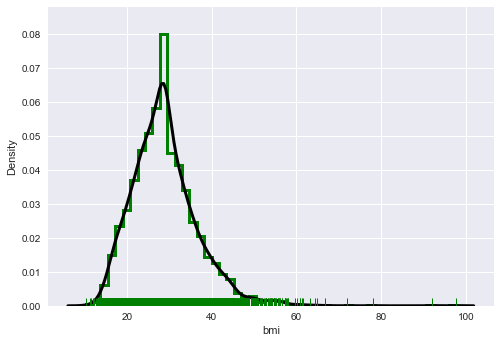

In [26]:
# body mass index distribution
distplot('bmi')

In [27]:
pie_graph(data_eda, 'Work type Distribution','work_type')

#### Average Glucose Level in blood distribution

c:\Users\Rahmatullah\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\Rahmatullah\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



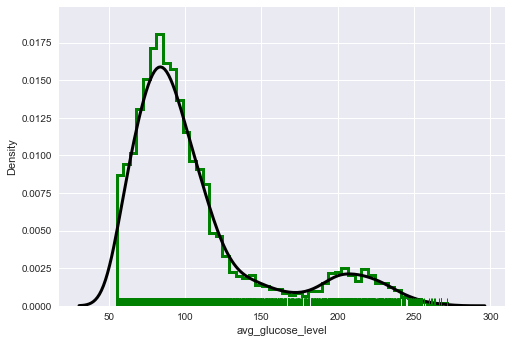

In [28]:
distplot('avg_glucose_level')

In [29]:
pie_graph(data_eda, 'Residence type Distribution','Residence_type')

In [30]:
pie_graph(data_eda,'Smoking Status Distribution','smoking_status')

In [31]:
pie_graph(data_eda, 'Stroke Distribution', 'stroke')

####Summary Statistics

1) **age**           - Age of the patient in Years

* We have seen that the number of people between the ages of 0 to 20 is 1025 and they represent approximately 210 percent
* We have seen that the number of people between the ages of 20 to 40 is 1219 and they represent approximately 24 percent
* We have seen that the number of people between the ages of 40 is 50 is 739 and they represent approximately 14 percent
* We have seen that the number of people between the ages of 50 to 60 is 823 and they represent approximately 15 percent
* We have seen that the number of people who 60 and older is 1304 and they represent approximately 25 percent
* We have also seen that **Mean Age**: is approximately 43 years old and **Minimum**: 8 month and **Maximum**: 82 years old.

2) **gender**           - Sex of the Patient

* Male Patients are 41.7%
* Female Patients are 58.6%
* other Patients are 0.0196%

3) **hypertension**            

* the patient who doesn't have hypertension represent 90%
* the patient who has hypertension represent 10%

4) **avg_glucose_level** - average glucose level in blood

* **Mean Resting Blood Pressure**: is approximately 106.1 and **Minimum**: 55.1 and **Maximum**: 82.

5) **bmi**         - body mass index

* **Mean Resting Blood Pressure**: is approximately 28.9 and **Minimum**: 10.3 and **Maximum**: 97.3.
* we have seen also that the majority of body mass index is between 20 and 35

6) **stroke**          

* who have not a stroke represent 95%
* who have a stroke represent 5%

7) **heart_disease**  

* the patient who doesn't have any heart diseases represent 94%
* the patient who has a heart disease represent 6%

8) **work_type**  

* 13.4% of patients are children
* 12.9% of patients are Govt_jov
* 0.4% of patients are Never_worked
* 57.2% of patients are Private
* 16% of patients are Self-employed

9) **ever_married**      

* No about 35%
* Yes about 65%

10) **id**   - unique identifier

11) **Residence_type**      

* Rural about 49%
* Urban about 51%

12) **smoking_status**            

* 17.3% of patients are formerly smoked >>>> * 37% of patients are never smoked
* 15.4% of patients are smokes
* 30.2% of patients are Unknown

#Data Visualization

####Categorical Feature (BarPlot)

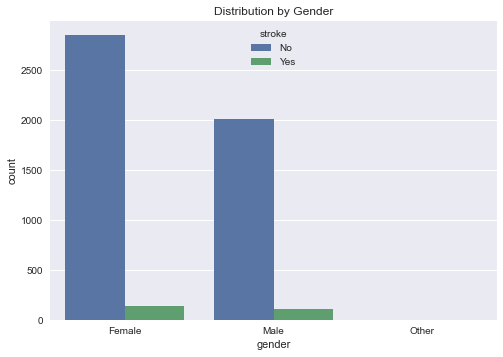

In [32]:
count_bar_plot(data_eda,'gender','stroke','Distribution by Gender')

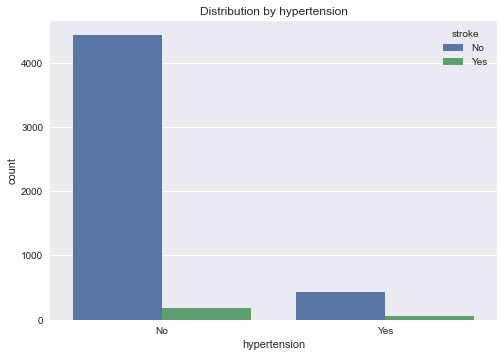

In [33]:
count_bar_plot(data_eda,'hypertension','stroke','Distribution by hypertension')

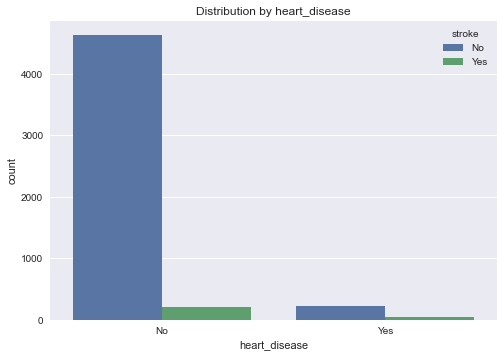

In [34]:
count_bar_plot(data_eda,'heart_disease','stroke','Distribution by heart_disease')

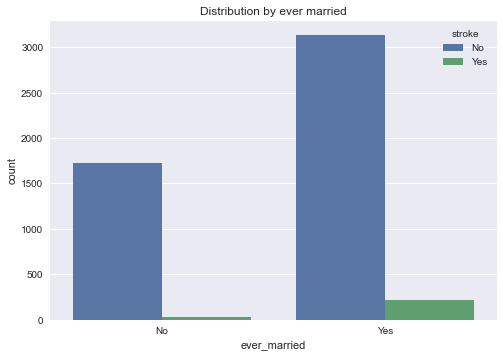

In [35]:
count_bar_plot(data_eda,'ever_married','stroke','Distribution by ever married')

In [36]:
group = data_eda.groupby(['stroke','work_type'],as_index = False).size().sort_values(by='size')
horizontal_bar_chart(df = group,x = 'stroke',y = 'size',color = 'work_type',title = 'Distribution of stroke by work type')

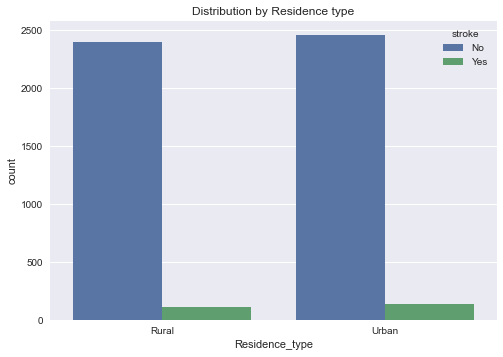

In [37]:
count_bar_plot(data_eda,'Residence_type','stroke','Distribution by Residence type')

In [38]:
group = data_eda.groupby(['stroke','smoking_status'],as_index = False).size().sort_values(by='size')
horizontal_bar_chart(df = group,x = 'stroke',y = 'size',color = 'smoking_status',title = 'Distribution of stroke by smoking status')

####Numerical Features (RegressionPlot)

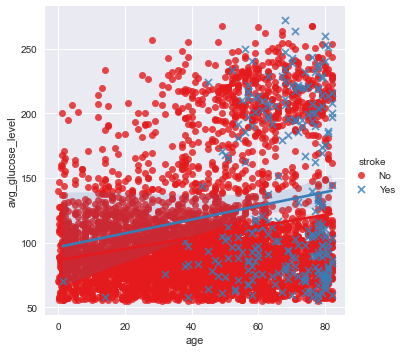

In [39]:
cnditioning_linear_plot('age','avg_glucose_level','stroke',data_eda)

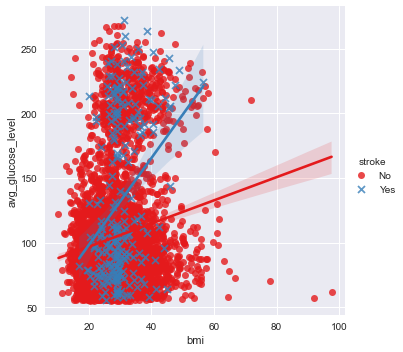

In [40]:
cnditioning_linear_plot('bmi','avg_glucose_level','stroke',data_eda)

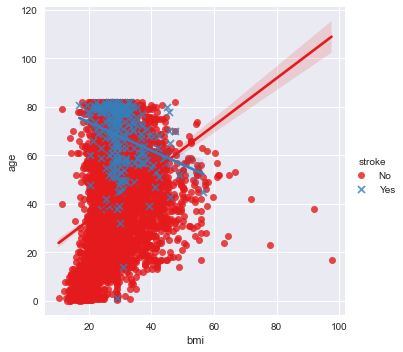

In [41]:
cnditioning_linear_plot('bmi','age','stroke',data_eda)

####Visualisation Short Summary

Avg glucose level is high with old people

BMI >40 have low avg glucose

Being unmarried reduces your risk of a stroke

Being a smoker or a formerly smoker increases your risk of having a stroke

more than 25% of strok cases They had hypertension

Female and male both have equal number of stroke cases while there is not any single case of stroke in other gender type.

Patient with private job have more number stroke cases then self employed and govt_job

There are few cases of strokes in children and those who are unemployed having no case Both Urban and rural have equal number of stroke cases.so this is not a useful feature.

Stroke has the highest correlation with age

As people start to age the risk of having a stroke is increasing most of stroke cases belong to 60-80 age group that means most of patients are in their older age.

Patients with stroke having heigher avg_glucose_level then 120.

#Feature Engineering

####Correlation Analysis

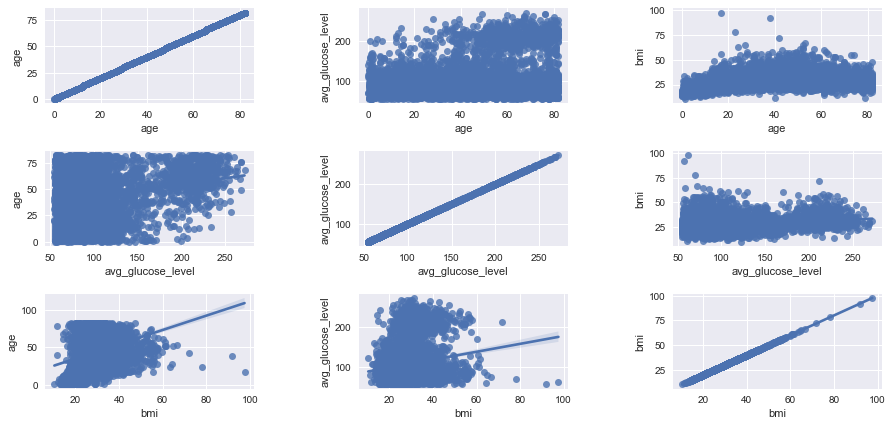

In [42]:
plt.figure(1, figsize=(15,7))
n = 0
for x in ['age','avg_glucose_level','bmi']:
    for y in ['age','avg_glucose_level','bmi']:
        n += 1
        plt.subplot(3,3,n)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        sns.regplot(x = x, y = y, data = df)
        plt.ylabel(y.split()[0] + ' ' + y.split()[1] if len(y.split()) > 1 else y)

plt.show()

* As we can see that the higher body mass index you get the higher average glucose level 
* We can also see that the the older you get the higher your body mass index will be

<AxesSubplot:>

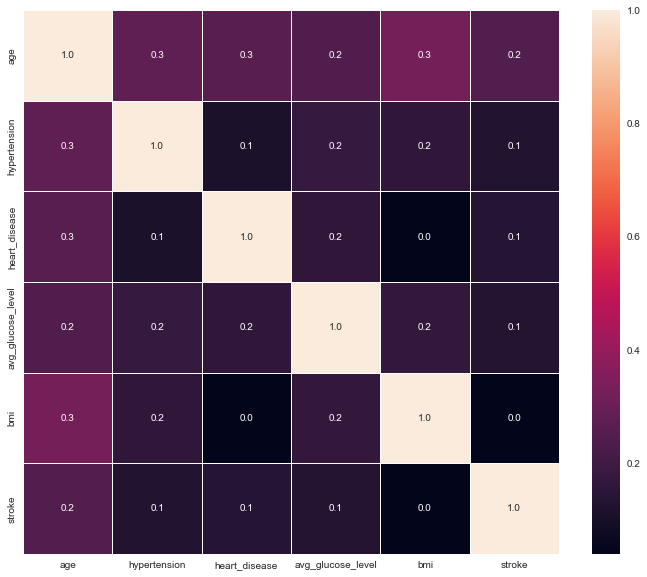

In [43]:
f, ax = plt.subplots(figsize = (12,10))
sns.heatmap(df.corr(),
            annot = True,
            linewidths = .5,
            fmt = '.1f',
            ax = ax)

In [44]:
df.corr()['stroke'].sort_values(ascending = False)

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.038947
Name: stroke, dtype: float64

####Converting 'object' Column to 'integer'

In [45]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [46]:
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1


In [47]:
df = pd.get_dummies(df)
df.head(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,28.893237,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0


In [48]:
df.shape

(5110, 22)

# Pre Modellling Steps

#### Declare feature vector and target variable

In [49]:
X = df.drop(columns = ['stroke'])
y = df['stroke']

####SMOTE Technique

In [50]:
sm = SMOTE(random_state=123)
X_sm , y_sm = sm.fit_resample(X,y)

print(f'''Shape of X before SMOTE:{X.shape}
Shape of X after SMOTE:{X_sm.shape}''',"\n\n")

print(f'''Target Class distributuion before SMOTE:\n{y.value_counts(normalize=True)}
Target Class distributuion after SMOTE :\n{y_sm.value_counts(normalize=True)}''')

Shape of X before SMOTE:(5110, 21)
Shape of X after SMOTE:(9722, 21) 


Target Class distributuion before SMOTE:
0    0.951272
1    0.048728
Name: stroke, dtype: float64
Target Class distributuion after SMOTE :
1    0.5
0    0.5
Name: stroke, dtype: float64


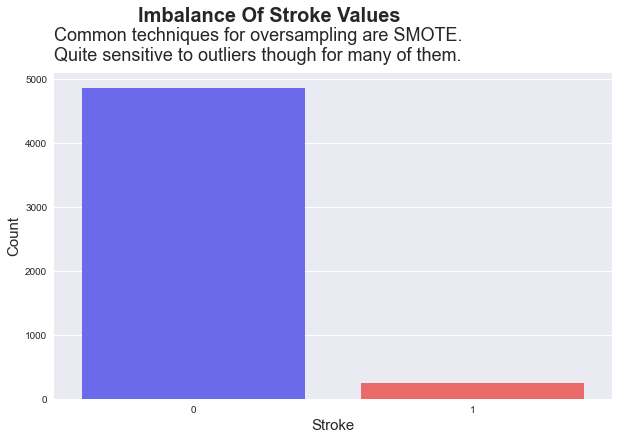

In [51]:
plt.figure(figsize=(10,6))
cp=sns.countplot(x=df["stroke"],palette="seismic")
plt.xlabel("Stroke",fontsize=15)
plt.ylabel("Count",fontsize=15)

plt.text(x=-0.2, y=5900, s='Imbalance Of Stroke Values', 
         fontsize=20, fontweight='bold')
plt.text(x=-0.5, y=5600, s='Common techniques for oversampling are SMOTE.', 
         fontsize=18)
plt.text(x=-0.5, y=5300, s='Quite sensitive to outliers though for many of them.', 
         fontsize=18)

plt.show()

#### Split data into separate training and test set

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm,
    y_sm,
    test_size = .2,
    random_state = 777)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7777, 21), (7777,), (1945, 21), (1945,))

### Scaling Data

In [98]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)   

### Machine Learning Models

Random Forest Classifier Model

Testing-set Accuracy score is: 0.970694087403599
Training-set Accuracy score is: 1.0


<AxesSubplot:>

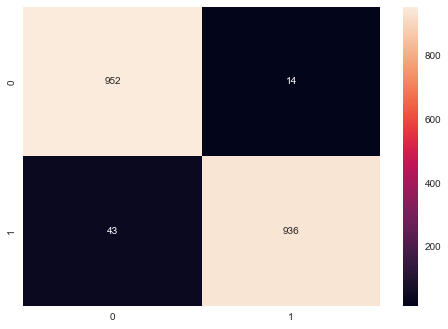

In [100]:
clf_rf = RandomForestClassifier(random_state=777)
clf_rf = clf_rf.fit(X_train,y_train)
y_pred_rf = clf_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred_rf)
print('Testing-set Accuracy score is:', acc)
print('Training-set Accuracy score is:',accuracy_score(y_train,clf_rf.predict(X_train)))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot = True, fmt = "d")

Ada Boost Classifier Model

AdaBoost Classifier Model Accuracy Score is: 0.9598971722365038


<AxesSubplot:>

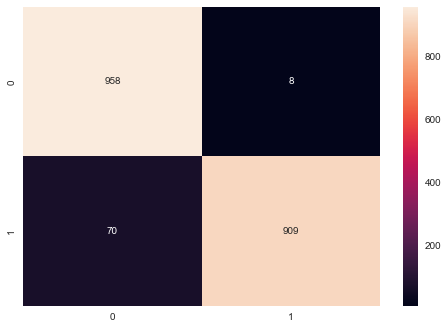

In [101]:
abc = AdaBoostClassifier(n_estimators = 50,
                         learning_rate = 1, 
                         random_state = 777)
abc.fit(X_train,y_train)
y_pred_abc = abc.predict(X_test)
acc = accuracy_score(y_test, y_pred_abc)
print('AdaBoost Classifier Model Accuracy Score is:',acc)
cm = confusion_matrix(y_test, y_pred_abc)
sns.heatmap(cm, annot = True, fmt="d")

Gradient Boosting Classifier Model Accuracy score is: 0.9609254498714653


<AxesSubplot:>

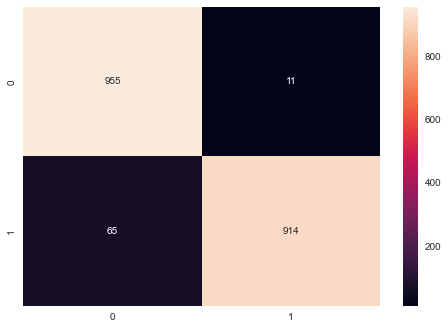

In [102]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
acc = accuracy_score(y_test, gb_pred)
print("Gradient Boosting Classifier Model Accuracy score is:", acc)
cm = confusion_matrix(y_test, gb_pred)
sns.heatmap(cm, annot = True, fmt="d")

KNN Model Acuuracy is: 0.9629820051413882


<AxesSubplot:>

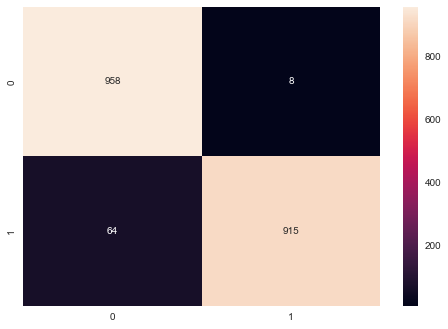

In [103]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
acc = knn.score(X_test, y_test)
print("KNN Model Acuuracy is:", acc)
cm = confusion_matrix(y_test, knn_pred)
sns.heatmap(cm, annot = True, fmt="d")

SVC Accuracy score is: 0.9598971722365038


<AxesSubplot:>

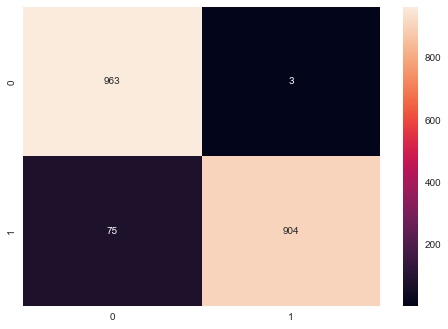

In [107]:
svc = SVC(random_state = 777)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
acc = svc.score(X_test, y_test)
print("SVC Accuracy score is:", acc)
cm = confusion_matrix(y_test, svc_pred)
sns.heatmap(cm, annot = True, fmt = "d")

In [108]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
acc = lr.score(X_test, y_test)
print("LogisticRegression accuracy score is:",acc)
report = classification_report(y_test, lr_pred)
print(report)

LogisticRegression accuracy score is: 0.9588688946015425
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       966
           1       1.00      0.92      0.96       979

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



Decision Tree accuracy score is : 0.9388174807197943


<AxesSubplot:>

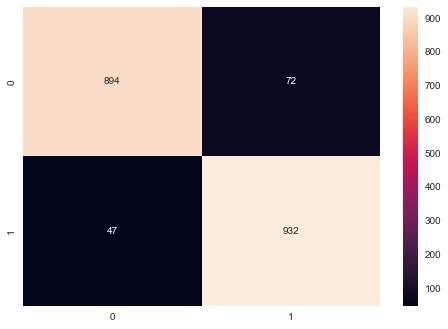

In [109]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
acc = accuracy_score(y_test, dt_pred)
print("Decision Tree accuracy score is :",acc)
cm = confusion_matrix(y_test, dt_pred)
sns.heatmap(cm, annot = True, fmt = "d")

0:	learn: 0.5723573	total: 4.72ms	remaining: 18.9ms
1:	learn: 0.4905162	total: 10.2ms	remaining: 15.3ms
2:	learn: 0.4163190	total: 15.1ms	remaining: 10.1ms
3:	learn: 0.3831668	total: 21.9ms	remaining: 5.46ms
4:	learn: 0.3212923	total: 27.7ms	remaining: 0us
Cat Boost Classifier accuracy score is: 0.9223650385604113


<AxesSubplot:>

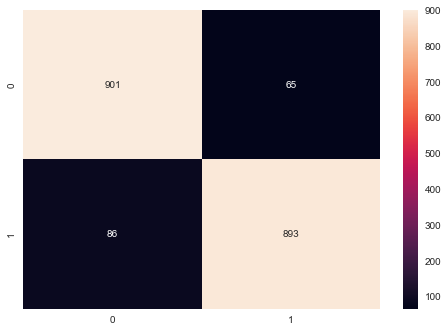

In [110]:
cbc = CatBoostClassifier( iterations=5, 
                          learning_rate=0.1 )
cbc = cbc.fit(X_train,y_train)
cbc_pred = cbc.predict(X_test)
acc = accuracy_score(y_test,cbc_pred)
print("Cat Boost Classifier accuracy score is:",acc)
cm = confusion_matrix(y_test,cbc_pred)
sns.heatmap(cm, annot = True, fmt = "d")

Voting Classifier Accuracy Score is: 
0.9753213367609255


<AxesSubplot:>

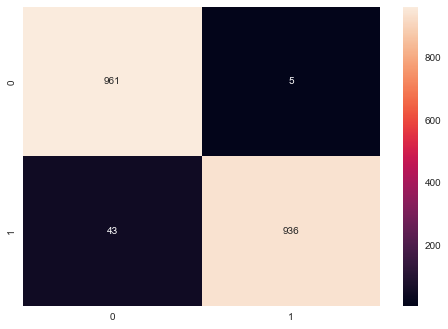

In [111]:
clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier()
clf3 =  KNeighborsClassifier(n_neighbors = 10)
eclf1 = VotingClassifier(estimators=[('gbc', clf1), ('lr', clf2), ('abc', clf3)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
print("Voting Classifier Accuracy Score is: ")
print(accuracy_score(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot = True, fmt="d")